# Predict Crime in the UK Using SageMaker

In [3]:
import sagemaker
bucket=sagemaker.Session().default_bucket()
prefix = 'sagemaker/DEMO-linlearn-dm'
 
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

In [4]:
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt                   
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import sagemaker 
import zipfile     # Amazon SageMaker's Python SDK provides many helper functions

# Get the data from SageMaker Feature Store

In [5]:
from sagemaker.session import Session
from sagemaker.feature_store.feature_group import FeatureGroup

region = boto3.Session().region_name
boto_session = boto3.Session(region_name=region)

sagemaker_client = boto_session.client(service_name='sagemaker', region_name=region)
featurestore_runtime = boto_session.client(service_name='sagemaker-featurestore-runtime', region_name=region)

feature_store_session = Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime
)

feature_group_name = "FG-ndcCrime-7dee9362" # replace with your feature group name 
feature_group = FeatureGroup(name=feature_group_name, sagemaker_session=feature_store_session)

In [6]:
# Build SQL query to features group
fs_query = feature_group.athena_query()
fs_table = fs_query.table_name
query_string = 'SELECT * FROM "'+fs_table+'"'
print('Running ' + query_string)

Running SELECT * FROM "fg-ndccrime-7dee9362-1673879553"


In [7]:
# Run Athena query. The output is loaded to a Pandas dataframe.
fs_query.run(query_string=query_string, output_location='s3://'+bucket+'/'+prefix+'/fs_query_results/')
fs_query.wait()
model_data = fs_query.as_dataframe()

In [8]:
model_data.head()

,outcome,gender_male,gender_female,gender_other,age_range_18-24,age_range_25-34,age_range_over_34,age_range_10-17,age_range_under_10,date_month_1,...,date_quarter_2,ethnicity_white,ethnicity_black,ethnicity_asian,ethnicity_other,ethnicity_mixed,coords,write_time,api_invocation_time,is_deleted
0,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.5,...,1.0,1.0,0.0,0.0,0.0,0.0,0.001479,2023-01-16 14:52:15.097,2023-01-16 14:52:15.097,False
1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,...,1.0,0.0,1.0,0.0,0.0,0.0,-0.003074,2023-01-16 14:52:15.097,2023-01-16 14:52:15.097,False
2,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.5,...,1.0,1.0,0.0,0.0,0.0,0.0,-0.000569,2023-01-16 14:52:15.097,2023-01-16 14:52:15.097,False
3,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.5,...,1.0,1.0,0.0,0.0,0.0,0.0,-0.002623,2023-01-16 14:52:15.097,2023-01-16 14:52:15.097,False
4,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.5,...,1.0,0.0,1.0,0.0,0.0,0.0,-0.007515,2023-01-16 14:52:15.097,2023-01-16 14:52:15.097,False


In [9]:
#remove unwanted columns
model_data = model_data.drop(['write_time', 'api_invocation_time', 'is_deleted'], axis=1)

In [10]:
model_data.head()

,outcome,gender_male,gender_female,gender_other,age_range_18-24,age_range_25-34,age_range_over_34,age_range_10-17,age_range_under_10,date_month_1,...,date_day_of_year_1,date_day_of_year_2,date_quarter_1,date_quarter_2,ethnicity_white,ethnicity_black,ethnicity_asian,ethnicity_other,ethnicity_mixed,coords
0,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.5,...,0.756771,0.65368,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.001479
1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,...,0.756771,0.65368,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-0.003074
2,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.5,...,0.756771,0.65368,0.0,1.0,1.0,0.0,0.0,0.0,0.0,-0.000569
3,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.5,...,0.756771,0.65368,0.0,1.0,1.0,0.0,0.0,0.0,0.0,-0.002623
4,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.5,...,0.756771,0.65368,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-0.007515


In [11]:
# Prepare data SageMaker's Linear Learner algorithm
# Amazon SageMaker's Linear Learner container expects data in CSV data format. 
# Note that the first column must be the target variable and the CSV should not include headers. 

In [12]:
# remove the headers
model_data.columns = range(model_data.shape[1])   # Delete headers

model_data.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.5,...,0.756771,0.65368,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.001479
1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,...,0.756771,0.65368,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-0.003074
2,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.5,...,0.756771,0.65368,0.0,1.0,1.0,0.0,0.0,0.0,0.0,-0.000569
3,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.5,...,0.756771,0.65368,0.0,1.0,1.0,0.0,0.0,0.0,0.0,-0.002623
4,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.5,...,0.756771,0.65368,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-0.007515


In [13]:
# separate data into train/test data split

#The model will be trained on 70% of data, it will then be evaluated on 20% of data to give us an estimate of the accuracy 
#we hope to have on "new" data, and 10% will be held back as a final testing dataset which will be used later on.

# Randomly sort the data then split out first 70%, second 20%, and last 10%
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), 
                                                  [int(0.7 * len(model_data)), int(0.9 * len(model_data))]) 

In [14]:
# Convert data to CSV
train_data.to_csv('train.csv', index=False, header=False)
validation_data.to_csv('validation.csv', index=False, header=False)
test_data.to_csv('test.csv', index=False, header=False)

In [15]:
#copy data to S3 for SageMaker to access
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')

# Training

In [16]:
#specify the ECR container location for Amazon SageMaker's implementation of XGBoost

container = sagemaker.image_uris.retrieve(region=boto3.Session().region_name, framework='xgboost', version='latest')

In [17]:
#Then, because we're training with the CSV file format, we'll create s3_inputs that our training function can use 
# as a pointer to the files in S3, which also specify that the content type is CSV.
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')
s3_input_test = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/test/'.format(bucket, prefix), content_type='csv')

First we'll need to specify training parameters to the estimator. This includes:

The ll algorithm container
The IAM role to use
Training instance type and count
S3 location for output data
Algorithm hyperparameters
And then a .fit() function which specifies:

S3 location for output data. In this case we have both a training and validation set which are passed in.

In [18]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)

xgb.set_hyperparameters(max_depth=5,eta=0.2,gamma=4,min_child_weight=6,subsample=0.8,silent=0,objective='binary:logistic',
                        eval_metric='auc', num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

INFO:sagemaker:Creating training-job with name: xgboost-2023-05-21-15-42-06-415


2023-05-21 15:42:07 Starting - Starting the training job...
2023-05-21 15:42:32 Starting - Preparing the instances for training.........
2023-05-21 15:44:06 Downloading - Downloading input data...
2023-05-21 15:44:46 Training - Downloading the training image...
2023-05-21 15:45:12 Training - Training image download completed. Training in progress...Arguments: train
[2023-05-21:15:45:25:INFO] Running standalone xgboost training.
[2023-05-21:15:45:25:INFO] File size need to be processed in the node: 601.86mb. Available memory size in the node: 8588.69mb
[2023-05-21:15:45:25:INFO] Determined delimiter of CSV input is ','
[15:45:25] S3DistributionType set as FullyReplicated
[15:45:26] 1762710x26 matrix with 45830460 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2023-05-21:15:45:26:INFO] Determined delimiter of CSV input is ','
[15:45:26] S3DistributionType set as FullyReplicated
[15:45:27] 503632x26 matrix with 13094432 entries loaded from /opt/ml/inpu

# Model Hosting w/ Endpoint Creation & Model Evaluation
Now that we have successfully trained our model, let’s deploy it and see how it does on the test data!

In [45]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: xgboost-2023-05-21-16-43-46-847
INFO:sagemaker:Creating endpoint-config with name xgboost-2023-05-21-16-43-46-847
INFO:sagemaker:Creating endpoint with name xgboost-2023-05-21-16-43-46-847


------!

In [20]:
#need to make sure data is in correct format for deployed model
from sagemaker.predictor import csv_serializer, json_deserializer

xgb_predictor.serializer = sagemaker.serializers.CSVSerializer()
xgb_predictor.deserializer = sagemaker.deserializers.JSONDeserializer()

In [21]:
test_data.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
880546,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.000000e-01,...,0.507415,0.861702,0.000000e+00,1.000000e+00,0.0,0.0,1.0,0.0,0.0,-0.000197
2085095,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.000000e+00,...,0.912846,-0.408304,1.000000e+00,-4.371139e-08,1.0,0.0,0.0,0.0,0.0,0.005324
1734339,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-8.742278e-08,...,-0.153891,-0.988088,-8.742278e-08,-1.000000e+00,0.0,1.0,0.0,0.0,0.0,0.001580
1494162,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.000000e-01,...,0.778764,0.627317,0.000000e+00,1.000000e+00,1.0,0.0,0.0,0.0,0.0,-0.050342
220295,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000e+00,...,0.980575,-0.196143,1.000000e+00,-4.371139e-08,0.0,1.0,0.0,0.0,0.0,-0.004079


# Inference

In [22]:
# run the prediction on a single observation
prediction = xgb_predictor.predict(np.array([1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.8660252094268799,0.5000002980232239,0.2993628978729248,
                                             -0.9541393518447876,0.7071067690849304,0.7071067690849304,-0.8124867677688599,0.582979679107666,
                                             -0.7221164703369141,0.6917715072631836,-1.0,1.1924880638503056e-08,1.0,0.0,0.0,0.0,0.0,
                                             -0.0260128165460627]))
       
#The response is the probability that the person will commit a crime
#Target value is 1
prediction

0.7229898571968079

In [23]:
# run the prediction on a single observation
prediction = xgb_predictor.predict(np.array([1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.866025447845459,0.4999999701976776,0.7247928380966187,
                                             0.6889668703079224,-0.4999997615814209,0.8660255670547485,0.8124868869781494,0.5829794406890869,
                                             0.8826788663864136,0.4699766635894775,0.0,1.0,1.0,0.0,0.0,0.0,0.0,-0.0005222935888651238]))
       
#The response is the probability that the person will commit a crime
#Target value is 0
prediction

0.6623328328132629

In [24]:
# Split target variable and feature variables
target_values = test_data[0]

target_values.head()

880546     1
2085095    1
1734339    1
1494162    0
220295     0
Name: 0, dtype: int64

In [25]:
#drop first column (ie target) of test data, the first column shouldn't be the target
test_data.drop(columns=test_data.columns[0], axis=1, inplace=True)

In [26]:
test_data.head()

,1,2,3,4,5,6,7,8,9,10,...,17,18,19,20,21,22,23,24,25,26
880546,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.000000e-01,8.660254e-01,...,0.507415,0.861702,0.000000e+00,1.000000e+00,0.0,0.0,1.0,0.0,0.0,-0.000197
2085095,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.000000e+00,-4.371139e-08,...,0.912846,-0.408304,1.000000e+00,-4.371139e-08,1.0,0.0,0.0,0.0,0.0,0.005324
1734339,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-8.742278e-08,-1.000000e+00,...,-0.153891,-0.988088,-8.742278e-08,-1.000000e+00,0.0,1.0,0.0,0.0,0.0,0.001580
1494162,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.000000e-01,8.660254e-01,...,0.778764,0.627317,0.000000e+00,1.000000e+00,1.0,0.0,0.0,0.0,0.0,-0.050342
220295,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000e+00,-4.371139e-08,...,0.980575,-0.196143,1.000000e+00,-4.371139e-08,0.0,1.0,0.0,0.0,0.0,-0.004079


In [27]:
#run predictions on the entire test data set
#It takes about 30 minutes for this code to execute

def predict(data, predictor, rows=500 ):
    #splits test dataset into 5 arrays of observations
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    
    for array in split_array:
        for observation in array:
            prediction = predictor.predict(observation)
            predictions = ','.join([predictions, str(prediction)])
            
    return np.fromstring(predictions[1:], sep=',')

#numpy array of predictions
predictions = predict(test_data.to_numpy(), xgb_predictor)
print(predictions)

[0.39247814 0.65806925 0.54111743 ... 0.54959214 0.59666777 0.47939888]


In [28]:
print(predictions[0])

0.3924781382083893


In [29]:
print(predictions[1])

0.6580692529678345


In [30]:
print(predictions[2])

0.5411174297332764


# Evaluate the model with a Confusion Matrix

In [31]:
#compare the actual values (ie, target) with the values predicted by the model
pred_test_df = pd.DataFrame({'Actual': target_values.to_numpy(), 'Predicted': predictions})

pred_test_df

,Actual,Predicted
0,1,0.392478
1,1,0.658069
2,1,0.541117
3,0,0.645443
4,0,0.371927
...,...,...
251811,1,0.646084
251812,1,0.502777
251813,1,0.549592
251814,0,0.596668


In [32]:
# convert to binary value for predictions w/ threshold of .5
rounded_predictions = [round(value) for value in predictions]

In [33]:
pred_test_df = pd.DataFrame({'Actual': target_values.to_numpy(), 'Predicted': rounded_predictions})

pred_test_df

,Actual,Predicted
0,1,0
1,1,1
2,1,1
3,0,1
4,0,0
...,...,...
251811,1,1
251812,1,1
251813,1,1
251814,0,1


In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

results = confusion_matrix(target_values.to_numpy(),rounded_predictions)
print(results)

[[ 51788  63524]
 [ 33969 102535]]


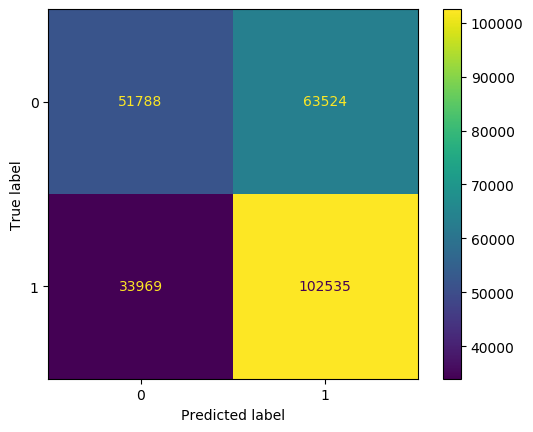

In [35]:
# visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=results, 
                              display_labels=['0','1'])
disp.plot(values_format='')
plt.show()

In [36]:
# run classification report
from sklearn.metrics import classification_report
 
print(classification_report(rounded_predictions, target_values.to_numpy()))

              precision    recall  f1-score   support

           0       0.45      0.60      0.52     85757
           1       0.75      0.62      0.68    166059

    accuracy                           0.61    251816
   macro avg       0.60      0.61      0.60    251816
weighted avg       0.65      0.61      0.62    251816



# Adding SageMaker Clarify to Detect Bias in the Data

In [58]:
from sagemaker import clarify

clarify_processor = clarify.SageMakerClarifyProcessor(
    role=role, instance_count=1, instance_type="ml.m5.xlarge", sagemaker_session=feature_store_session
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.0.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


## Define Data Config

#### Identifies where the data to analyze is found in S3 + where to put the final report + what we are predicting and the type of dataset being used

In [59]:
bias_report_output_path = "s3://{}/{}/clarify-bias".format(bucket, prefix)

columns_as_list = ['outcome', 'gender_male', 'gender_female', 'gender_other', 'age_range_18-24', 'age_range_25-34', 'age_range_over_34', 'age_range_10-17', 'age_range_under_10', 'date_month_1', 'date_month_2', 'date_day_1', 'date_day_2', 'date_hour_1', 'date_hour_2', 'date_week_of_year_1', 'date_week_of_year_2', 'date_day_of_year_1', 'date_day_of_year_2', 'date_quarter_1', 'date_quarter_2', 'ethnicity_white', 'ethnicity_black', 'ethnicity_asian', 'ethnicity_other', 'ethnicity_mixed', 'coords']

bias_data_config = clarify.DataConfig(
    s3_data_input_path='output.csv',
    s3_output_path=bias_report_output_path,
    label="outcome", #what the model will predict
    headers=columns_as_list,
    dataset_type="text/csv",
)

## Define Bias Config

#### Defines the bias detection settings like the favorable outcomes in the label-value-threshold and the facets (ie., sensitive column) we want to monitor for bias

### Run pre-bias training over the favored value, no crime

In [60]:
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[0], #favorable values from the target or outcome, 0 means no crime
    facet_name="ethnicity_black"
)

### Run pre-training job

In [61]:
%time
clarify_processor.run_pre_training_bias(
    data_config = bias_data_config,
    data_bias_config = bias_config,
    methods='all'
)

INFO:sagemaker.clarify:Analysis Config: {'dataset_type': 'text/csv', 'headers': ['outcome', 'gender_male', 'gender_female', 'gender_other', 'age_range_18-24', 'age_range_25-34', 'age_range_over_34', 'age_range_10-17', 'age_range_under_10', 'date_month_1', 'date_month_2', 'date_day_1', 'date_day_2', 'date_hour_1', 'date_hour_2', 'date_week_of_year_1', 'date_week_of_year_2', 'date_day_of_year_1', 'date_day_of_year_2', 'date_quarter_1', 'date_quarter_2', 'ethnicity_white', 'ethnicity_black', 'ethnicity_asian', 'ethnicity_other', 'ethnicity_mixed', 'coords'], 'label': 'outcome', 'label_values_or_threshold': [0], 'facet': [{'name_or_index': 'ethnicity_black'}], 'methods': {'report': {'name': 'report', 'title': 'Analysis Report'}, 'pre_training_bias': {'methods': 'all'}}}


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


INFO:sagemaker:Creating processing-job with name Clarify-Pretraining-Bias-2023-05-21-17-27-55-849


..............................2023-05-21 17:33:05,408 logging.conf not found when configuring logging, using default logging configuration.
2023-05-21 17:33:05,409 Starting SageMaker Clarify Processing job
2023-05-21 17:33:05,409 Analysis config path: /opt/ml/processing/input/config/analysis_config.json
2023-05-21 17:33:05,409 Analysis result path: /opt/ml/processing/output
2023-05-21 17:33:05,409 This host is algo-1.
2023-05-21 17:33:05,409 This host is the leader.
2023-05-21 17:33:05,409 Number of hosts in the cluster is 1.
2023-05-21 17:33:05,411 Running Python / Pandas based analyzer.
2023-05-21 17:33:05,411 Dataset type: text/csv uri: /opt/ml/processing/input/data
2023-05-21 17:33:05,424 Loading dataset...
/usr/local/lib/python3.9/site-packages/analyzer/data_loading/csv_data_loader.py:330: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_tmp, ignore_index=True)
2023-05-21 17:33:

### Understanding the report output

Class Imbalance (CI) – if we have equal representation across the dataset (perfectly balanced class gives a value of 0) , the value is .557 – means the balance isn’t that great

Difference in Proportions of Labels (DPL) -- measures the distribution of positive outcomes (no crime) across facet values, the value is -.018, the farther this value is from zero, the more bias in the data 

# Clean-up
If you’re ready to be done with this notebook, please run the cell below. This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [62]:
xgb_predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: xgboost-2023-05-21-16-43-46-847
INFO:sagemaker:Deleting endpoint with name: xgboost-2023-05-21-16-43-46-847
